In [26]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,accuracy_score
import joblib
import os
from datetime import datetime
from utils import add_custom_features



df=pd.read_csv('./data/cleaned_churn_data.csv')
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


# 📊 Feature Selection and Engineering for Customer Churn Prediction

This section summarizes the important decisions for building a churn prediction model using the Telco Customer Churn dataset.

---

## ✅ Features to Keep

These features show strong correlation with `Churn` or have strong business relevance:

| Feature             | Reason |
|---------------------|--------|
| `tenure`            | Customers with longer tenure tend to stay  
| `Contract`          | Long-term contracts reduce churn  
| `OnlineSecurity`    | Indicates digital safety behavior  
| `TechSupport`       | Support usage shows engagement  
| `MonthlyCharges`    | Higher charges may lead to dissatisfaction  
| `PaperlessBilling`  | Slight correlation — behavior insight  
| `InternetService`   | Type of internet has impact on churn  
| `PaymentMethod`     | Certain payment types correlate with churn  
| `SeniorCitizen`     | Demographic indicator

---

## ❌ Features to Drop

These features are either weakly correlated with `Churn`, redundant, or irrelevant:

| Feature             | Reason |
|---------------------|--------|
| `customerID`        | Just an identifier  
| `TotalCharges`      | Highly correlated with tenure × monthly charges  
| `gender`            | No meaningful impact on churn  
| `Partner`, `Dependents` | Weak correlation  
| `PhoneService`, `MultipleLines` | Overlap, low impact  
| `StreamingTV`, `StreamingMovies` | Optional, weak signal  
| `DeviceProtection`, `OnlineBackup` | Low impact in this dataset

---

## 🛠️ New Features (Engineered)

These features are created to capture deeper patterns and customer behavior:

### 1. `NumServices`
**Definition:** Count of services the customer uses  
**Why:** More services = more engaged = less churn 

### 2. `tenure_group`
**Definition:** Bins of customer tenure 

**Why:** Helps model customer lifecycle stages

### 3. `HighMonthlyCharges`
**Definition:** Binary flag for high monthly charges (> ₹80 or custom threshold) 

**Why:** High charges may indicate dissatisfaction

### 5. `IsSeniorDependent`
**Definition:** Combines senior citizen status and dependents 

**Why:** Targets unique age + family support segment

### 5. `PricePerService`
**Definition:** Cost per service used 

**Why:** Reflects customer’s perceived value

## In this project, we use a scikit-learn `Pipeline` to handle:
- Feature engineering
- Categorical encoding
- Scaling (if needed)
- Modeling

This ensures:
- Clean code
- No data leakage
- Seamless deployment

In [27]:
# Step 1: Feature Engineering Function
# make sure to define the function in utils.py
# Step 2: Define feature pipeline block
feature_block = FunctionTransformer(add_custom_features, validate=False)


In [28]:

categorical_cols = ['gender', 'SeniorCitizen','InternetService', 'OnlineSecurity',
                    'TechSupport', 'Contract', 'PaperlessBilling',
                    'PaymentMethod', 'IsSeniorDependent']

numerical_cols = ['tenure', 'MonthlyCharges',
                  'NumServices', 'HighMonthlyCharges', 'PricePerService']

In [29]:
# Step 4: Preprocessing block

#A ColumnTransformer lets you apply different preprocessing steps to different columns:
preprocessor=ColumnTransformer(transformers=[
    ('num',MinMaxScaler(),numerical_cols),
    ('cat',OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
   remainder='drop' # Drops any other columns, including the drop_columns
   )

# Data Preprocessing

**Splitting the data into train and test sets**

In [30]:
# Prepare features and target
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'No': 0, 'Yes': 1})  # Convert to numeric for testing in XGBoost

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


### Baseline Model
**We will use a  baseline model to test if the problem is learnable.**

In [31]:
def create_pipeline(classifier):
    return Pipeline([
        ('feature_engineering', feature_block),
        ('preprocessing', preprocessor),
        ('classifier', classifier)
    ])

In [32]:


model_params = {
    'logistic_regression': {
        'model':  create_pipeline(LogisticRegression(solver='liblinear')),
        'params': {
            'classifier__C': np.logspace(-3, 2, 6),  # [0.001, 0.01, 0.1, 1, 10, 100]
            'classifier__penalty': ['l1', 'l2']
        }
    },
    'random_forest': {
        'model': create_pipeline( RandomForestClassifier(random_state=42)) ,
        'params': {
            'classifier__n_estimators': [50, 100, 150, 200],
            'classifier__max_depth': [5, 10, 15, 20],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__bootstrap': [True, False]
        }
    },
    'xgboost': {
        'model': create_pipeline(XGBClassifier(eval_metric='logloss', verbosity=0)),
        'params': {
            'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__n_estimators': [100, 150],
    'classifier__gamma': [0, 0.1, 0.2]
        }
    }
}

In [33]:


scores = []

for model_name, mp in model_params.items():
    print(f" Tuning {model_name}...")
    clf = RandomizedSearchCV(
        mp['model'],
        mp['params'],
        n_iter=20,           # only try 20 combinations
        cv=3,                # 3-fold cross-validation
        scoring='accuracy',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    clf.fit(X_train, y_train)
    
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

# Results DataFrame
model_score_df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
model_score_df

 Tuning logistic_regression...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\amrit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning:

The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.



 Tuning random_forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
 Tuning xgboost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


,model,best_score,best_params
0,logistic_regression,0.802272,"{'classifier__penalty': 'l1', 'classifier__C':..."
1,random_forest,0.798367,"{'classifier__n_estimators': 200, 'classifier_..."
2,xgboost,0.801207,"{'classifier__subsample': 0.8, 'classifier__n_..."


In [34]:
for i, row in model_score_df.iterrows():
    print(f"Model: {row['model']}")
    print(f"Best Score: {row['best_score']}")
    print(f"Best Params: {row['best_params']}")
    print("-" * 50)

Model: logistic_regression
Best Score: 0.8022719204827831
Best Params: {'classifier__penalty': 'l1', 'classifier__C': np.float64(0.1)}
--------------------------------------------------
Model: random_forest
Best Score: 0.7983670571529996
Best Params: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 20, 'classifier__bootstrap': False}
--------------------------------------------------
Model: xgboost
Best Score: 0.8012069577564785
Best Params: {'classifier__subsample': 0.8, 'classifier__n_estimators': 150, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0, 'classifier__colsample_bytree': 1.0}
--------------------------------------------------


✅ Accuracy on Test Data: 73.31%

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80      1035
           1       0.50      0.80      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.73      0.75      1409



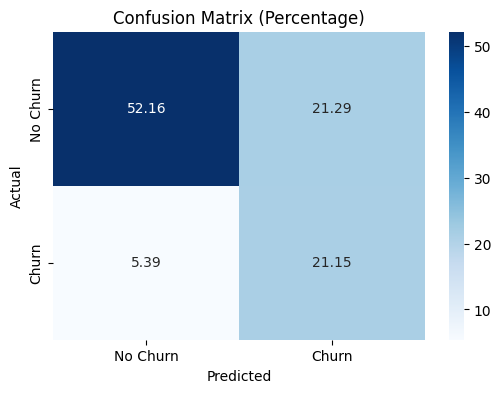

In [35]:


# Best Logistic Regression model based on GridSearchCV
logistic_model = Pipeline(steps=[
    ('feature_engineering', feature_block),
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(
        penalty='l1',
        C=0.1,
        solver='liblinear',
        class_weight='balanced'  # 💡 This is the key change
    ))
])

# Fit on the full training data
logistic_model.fit(X_train, y_train)

# Predict on test data
y_pred = logistic_model.predict(X_test)

# Evaluate
accuracy=accuracy_score(y_test, y_pred)
print("✅ Accuracy on Test Data: {:.2f}%".format(accuracy * 100))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
cm= confusion_matrix(y_test, y_pred)
cm_percent = cm / cm.sum() * 100  # Convert to percentages

# Plotting
plt.figure(figsize=(6, 4))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])

plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## ⚠️ Limitations of Logistic Regression

While Logistic Regression was a strong baseline, it had some key limitations:

- **Low Recall for Churn class (1):** It correctly identified only 53% of churned customers, which is risky in churn prediction.
- **F1-score imbalance:** The performance on the minority class (churn) was not as strong, leading to an F1-score of just 58%.
- **Linear Assumptions:** It assumes a linear relationship between features and the log-odds of the outcome, which may not capture complex patterns in the data.
- **Sensitivity to Class Imbalance:** Despite using `class_weight='balanced'`, it still struggled to detect many churners accurately.

Due to these limitations, we explored ensemble techniques to boost performance.

c:\Users\amrit\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning:

[23:03:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.81      0.84      1035
           1       0.56      0.68      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.77      0.78      1409



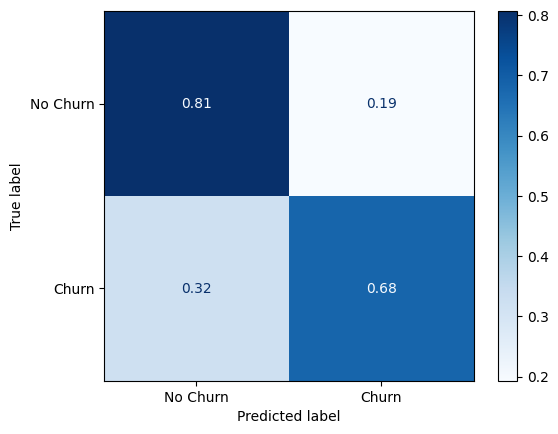

In [36]:


# Define the individual models with best parameters (or reasonable ones)
log_reg = LogisticRegression(
    penalty='l1',
    C=0.1,
    solver='liblinear',
    class_weight='balanced'
)

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)

xgb_clf = XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# VotingClassifier (Hard Voting or Soft Voting)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_reg),
        ('rf', rf_clf),
        ('xgb', xgb_clf)
    ],
    voting='soft'  # use 'hard' for label majority voting
)

# Final Ensemble Model Pipeline
model = Pipeline(steps=[
    ('feature_engineering', feature_block),
    ('preprocessing', preprocessor),
    ('classifier', voting_clf)
])

# Fit on training data
model.fit(X_train, y_train)

# Predict on test data
y_pred_ensemble = model.predict(X_test)

# Evaluate

print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_ensemble, 
    display_labels=['No Churn', 'Churn'], 
    cmap='Blues',
    normalize='true'  # 🔄 percent values
)

In [37]:

# Create a folder for versioned models
os.makedirs("models", exist_ok=True)

# Create a unique filename with date
date_str = datetime.now().strftime("%Y_%m_%d_%H%M%S")
model_name = f"final_model_{date_str}.pkl"

# Save the trained ensemble model
joblib.dump(model, f"models/{model_name}")

print(f"✅ Ensemble model saved successfully as '{model_name}'")

✅ Ensemble model saved successfully as 'final_model_2025_07_16_230316.pkl'
